# **Deep Learning (Data Exploration)** <br/>
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>

## Group Members
```
20220604 - Adriana Monteiro - 20220604@novaims.unl.pt
20170746 - Inês Nascimento - r20170746@novaims.unl.pt
20220640 - Janaina Santos - 20220640@novaims.unl.pt
20221396 - Stanislav Slesarev - 20221396@novaims.unl.pt
20220609 - Samuel Santos - 20220609@novaims.unl.pt
```
## Data Source link:
https://drive.google.com/drive/folders/1QjoneRXXJAKTP6IdfT0uFn2Qn2CBn1xt?usp=share_link

## Summary

This Notebook contains the exploration of the dataset.

## Introduction

The dataset, provided by a hospital in Iran, contains 3242 PBS images from 89 patients suspected of having malignant lymphoblasts. The images were taken through a microscope lens. 

Our objective with this project is to predict, trough the images of the dataset, if a patient has leukaemia of types, labeled as "Pre-B", "early Pre-B" and "Pro-B" or doesn't have leukemia, labeled as "Benign". 

## Findings

- We have four classes, three of which are cancer (Multiclassification);
- Images are consistent in the way they are obtained and in image format (.jpg);
- In terms of dimensions, the images have 2 different sizes;
- There are 40 repeated images;
- All images have visible microscope lens damage in the same areas;
- Some images are blurry or have a "black spot".


## References

1. Split Folders package, [Documentation](https://pypi.org/project/split-folders/);
2. Hash, [Documentation](https://docs.python.org/3/library/hashlib.html);
3. Detecting bluriness in images, [Source](https://www.kaggle.com/code/eladhaziza/perform-blur-detection-with-opencv);
4. TensorFlow, [Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).



## 1. Notebook setup

### 1.1. Instructions

To run this Notebook, you should:

 - Add the folder (link) as a shortcut to your google drive home/root directory:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

### 1.2. Imports

In [ ]:
# Importing the needed libraries

import tensorflow as tf

import tensorflow_datasets as tfds

import os
import time
import shutil
import random 
import hashlib

import numpy as np
import pandas as pd
from scipy.ndimage import variance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from google.colab import widgets

import cv2
from cv2 import IMREAD_COLOR,IMREAD_UNCHANGED
from PIL import Image
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize


### 1.2. Define global parameters/objects

In [ ]:
# Parameters to run the Notebook

dicParams = {}
dicParams['gdrive'] = True

# link to the google drive shortcut folder
dicParams["data_folder"] = '/content/drive/MyDrive/project/'

In [ ]:
# Paths of the folders 
paths_og = [
    
    dicParams['data_folder']+ 'Blood cell Cancer [ALL]/[Malignant] Pre-B',
     dicParams['data_folder']+'Blood cell Cancer [ALL]/[Malignant] Pro-B',
     dicParams['data_folder']+'Blood cell Cancer [ALL]/Benign',
     dicParams['data_folder']+'Blood cell Cancer [ALL]/[Malignant] early Pre-B'
]

### 1.3. Mounting the drive

In [ ]:
# set drive

gdrive = True

if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## Exploration

### 2.1. Sample of the dataset

The dataset has four classes: 
  - [Malignant] early Pre-B
  - [Malignant] Pre-B
  - [Malignant] Pro-B
  - Benign


In the next cell, we show the first image of each category folder:

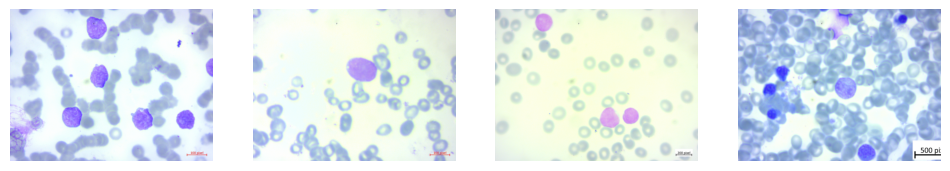

In [ ]:
# Sample of the first image of each folder/ class 

# Define the paths to the image directories
paths_sample = [dicParams['data_folder']+ 'Blood cell Cancer [ALL]/[Malignant] early Pre-B/Sap_148 (1).jpg',
        dicParams['data_folder']+ 'Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_00s2.jpg',
        dicParams['data_folder']+ 'Blood cell Cancer [ALL]/[Malignant] Pro-B/Snap_001.jpg',
        dicParams['data_folder']+ 'Blood cell Cancer [ALL]/Benign/Snap_001 (3).jpg']

# Create the subplots and loop through the image paths to display each image
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, path in enumerate(paths_sample):
    with Image.open(path) as img:
        axs[i].imshow(img)
        axs[i].axis('off')


### 2.1. Image Format

Here we identify the format of each image and count how many have a specific format:

In [ ]:
# Identify the format of all images

# Empty dictionary to save image types
image_types = {}

# Iterate over each folder path
for path in paths_og:
    for file in os.listdir(path):
        # Detect image extension 
        type_image = os.path.splitext(file)[1]
        if type_image not in image_types:
            image_types[type_image] = 1
        else:
            image_types[type_image] += 1

# Print the final output about images type 
print("Image type\tTotal\n" + "_____________________")
for type_image, count in image_types.items():
    print(f"{type_image}\t\t{count}")

Image type	Total
_____________________
.jpg		3242


The dataset has a total of 3242 images and all of them are in .jpg format.

### 2.2. Dimensions of the dataset

Next, we count how many images are there in each class:

In [ ]:
# Calculate both the total number of images per class and in total
images_class= [len(os.listdir(path)) for path in paths_og]
total_images = sum(images_class)

# Average per class
avg_class= total_images / len(paths_og)

# Standard deviation per class
std_dev= (sum([(x - avg_class)**2 for x in images_class]) / len(paths_og))**0.5

# Check if the dataset is balanced or unbalanced
if std_dev<= avg_class* 0.1:
    print("This dataset is balanced.")
else:
    print("This dataset is unbalanced.")

# Table with each class and their percentage over all the dataset
classes= ["[Malignant] Pre-B", "[Malignant] Pro-B", "Benign", "[Malignant] early Pre-B"]
count = images_class
weight = [count[i]/total_images for i in range(len(count))]
percentage = [str(round(weight[i]*100, 2)) + "%" for i in range(len(count))]
df = pd.DataFrame({'Category': classes, 'Count': count, 'Percentage': percentage})

print(df)


This dataset is unbalanced.
                  Category  Count Percentage
0        [Malignant] Pre-B    955     29.46%
1        [Malignant] Pro-B    796     24.55%
2                   Benign    512     15.79%
3  [Malignant] early Pre-B    979      30.2%


From the output above, we assess that not all classes are of the same size. We also notice that the class "[Malignant] early Pre-B", which has the highest amount of images, is almost double the size of the minority class ("Benign"). The other two classes are approximately the same size. We can conclude that the dataset is not balanced, even if it's not an extreme case.

### 2.3. Image Size

In the cell below we check for different image sizes and count how much of a unique image size exists:

In [ ]:
# Check all images size

# Empty dictionary to save the counts
counts = {}

# Iterate over directories and count all images 
for directory in paths_og:
    counts[directory] = {}
    # Iterate through the images
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            # The way to open all images without exceptions
            try:
                image = Image.open(image_path)
                w, h = image.size # width and height
                channels = 3  # RGB 
                size = f"{w}x{h}" # size

                if size not in counts[directory]:
                    counts[directory][size] = 0
                counts[directory][size] += 1
            # In case of something goes wrong
            except:
                pass

# Dataframe creation 
df = pd.DataFrame(counts)

# Rename the output name of the columns
df.columns = [col.split("/")[-1] for col in df.columns]

# Replace a missing values with 0
df = df.fillna(0)

# Remove the decimal point
df = df.astype(int).astype(str).replace('\.0', '')

# Print the final output
print(df)


          [Malignant] Pre-B [Malignant] Pro-B Benign [Malignant] early Pre-B
1024x768                955               789    472                     979
2560x1920                 0                 7     39                       0


We detect two different image sizes, (1024x768) and (2560x1920). 

While images from "[Malignant] Pre-B" and "[Malignant] early Pre-B", are all of the size (1024x768), the other two classes also have some images of size (2560x1920).

There is a total of 3195 images of size (1024x768) and 46 of size (2560x1920). 

### 2.4. Detecting Duplicated Images in the Dataset

In the next cell, we identify duplicates by computing the MD5 hash of each image file. If the image is considered duplicated, it prints both the original and the duplicate image paths.

In [ ]:
# Identify the images that are repeated

# Determine an image hash
def get_hash(paths):
    with open(paths, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    return image_hash

# Dictionary to track the picture hashes
hashes = {}

# Count the number of duplicated images
duplicated_count = 0

# Repeat for each directory path
for path in paths_og:
    # Iterate over the images 
    for root, dirs, files in os.walk(path):
        for file in files:
            paths = os.path.join(root, file)
            image_hash = get_hash(paths)
            if image_hash in hashes:
                print(f"Duplicate found: {paths_og} and {hashes[image_hash]}")
                duplicated_count += 1
            else:
                hashes[image_hash] = paths_og

# Print the duplicated images found
print(f"\nTotal of duplicated images found: {duplicated_count}")


Duplicate found: ['/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pre-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pro-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/Benign', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] early Pre-B'] and ['/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pre-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pro-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/Benign', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] early Pre-B']
Duplicate found: ['/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pre-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] Pro-B', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/Benign', '/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[Malignant] early Pre-B'] and ['/content/drive/MyDrive/project/Blood cell Cancer [ALL]/[

In total, the dataset has 40 duplicated images.

### 2.5. Detecting defects in the Images

#### 2.5.1 Detecting Blurry Images

Next, we show an example of an extremely blurry image in the dataset. We used a code snippet (Reference nr. 3) to evaluate the degree of bluriness, which is represented by the label in the upper left corner of the image below.

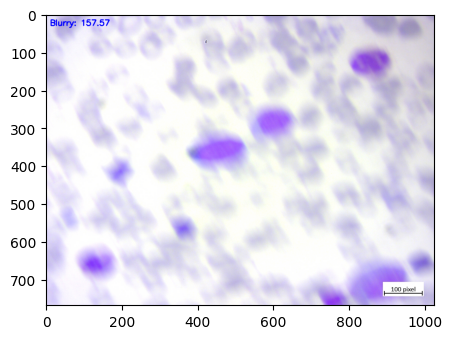

In [ ]:
# Detected totally/extreme blurry images

# Define the paths to the image directories
path_img = ['/content/drive/MyDrive/project/Blood cell Cancer [ALL]/Benign/Sap_013 (25).jpg'.format(i) for i in range(1,8)]

# Convert from BGR to RGB 
def RGB_funct(image_RGB):
    images = cv2.cvtColor(image_RGB, cv2.COLOR_BGR2RGB)
    return images

# Calculate the Laplacian variance
def define_laplacian(image_):
    color = cv2.cvtColor(image_, cv2.COLOR_RGB2BGR)
    return cv2.Laplacian(color, cv2.CV_64F).var()

# Detect if the image is 'blurry' or 'not blurry' 
def blurr_detec(paths,threshold):
    fig=plt.figure(figsize=(5, 8))
    i = 0
    for path in path_img:
        img = cv2.imread(path)
        output = "Not Blurry" 
        dl = define_laplacian(img)
        if dl < threshold: 
            output = "Blurry"
        picture_rgb = RGB_funct(img)
        cv2.putText(picture_rgb, "{}: {:.2f}".format(output, dl), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # size of the output  pictures
        plt.imshow(picture_rgb)
    plt.show()  

blurr_detec(path_img, 275) # Define the threshold of blurriness


There are 36 blurry images, either by "movement" or because they are unfocused. All classes have the presence of this type of defect, some categories more than others.

The amount of blurry images in each class is:
 - "[Malignant] early Pre-B": 19
 - "Benign": 8
 - "[Malignant] Pro-B": 5 
 - "[Malignant] Pre-B": 4

#### 2.5.2 Microscope lens damage


We detected that all of the images have 3 damaged areas. On the cell below, we show an exmaple of an image with these spots circled in red.

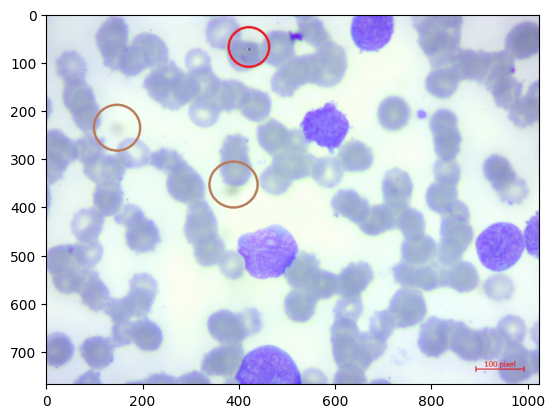

In [ ]:
# Sample image of a microscope lens damaged detected

# Define the paths to the image directories
path_lens = '/content/drive/MyDrive/project/microscope_dots.jpg'

img_lens = Image.open(path_lens)

plt.imshow(img_lens) # Define the threshold of blurriness

We detected that these three spots always occur in the same places. Since all images have these defects, this will not be a problem.

#### 2.5.3 Black Spots on Images

We also detected that some images have 'black spots'. Below there's an example of an image that has that defect:

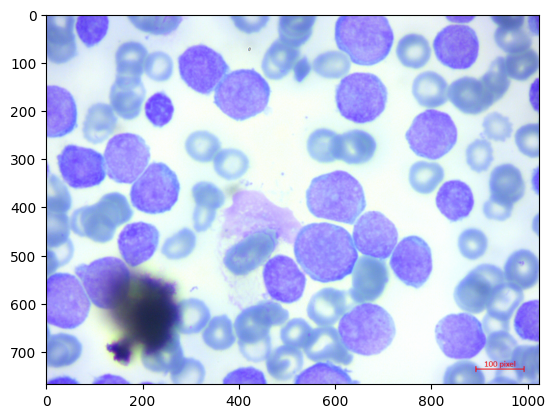

In [ ]:
# Sample image of a black spot detected

# Define the paths to the image directories
path_spot = dicParams['data_folder']+'Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_668.jpg'

img_spot = Image.open(path_spot)

plt.imshow(img_spot) # Define the threshold of blurriness



In total, we found 10 images with this black spot, five in class "[Malignant] early Pre-B" and the other five in class "[Malignant] Pre-B". The other two classes do not have any images with this particularity.

Since the number of images with this is not significant compared to the total number of images of the dataset, it will not have a negative impact on our analysis.